In [1]:
import pandas as pd
import networkx as nx
import community
import matplotlib.pyplot as plt
import random
import tqdm
import numpy as np
import random
from tqdm import tqdm_notebook
from collections import Counter

In [2]:
data = pd.read_csv('sexual_contacts.csv', delimiter = ';', header=None, skiprows=24)
data[0] = data[0].apply(lambda s: 'f'+str(s))
data[1] = data[1].apply(lambda s: 'm'+str(s))
G = nx.from_pandas_dataframe(df=data, source=0, target=1)

In [3]:
M = set([v for v in G.nodes() if v[0] == 'm'])
F = set([v for v in G.nodes() if v[0] == 'f'])

In [4]:
#функция из networkx, модифированная с учетом требования о двудольности графа

def my_double_edge_swap(G, nswap=1, max_tries=100):
    G_copy = G.copy()
    if G_copy.is_directed():
        raise nx.NetworkXError(
            "double_edge_swap() not defined for directed graphs.")
    if nswap > max_tries:
        raise nx.NetworkXError("Number of swaps > number of tries allowed.")
    if len(G_copy) < 4:
        raise nx.NetworkXError("Graph has less than four nodes.")
    n = 0
    swapcount = 0
    keys, degrees = zip(*G_copy.degree())  # keys, degree
    cdf = nx.utils.cumulative_distribution(degrees)  # cdf of degree
    while swapcount < nswap:
        (ui, xi) = nx.utils.discrete_sequence(2, cdistribution=cdf)
        if ui == xi:
            continue  # same source, skip
        u = keys[ui]  # convert index to label
        x = keys[xi]
        if (u in M and x in M) or (u in F and x in F):
            continue
        # choose target uniformly from neighbors
        v = random.choice(list(G_copy[u]))
        y = random.choice(list(G_copy[x]))
        if v == y:
            continue  # same target, skip
        if (x not in G_copy[u]) and (y not in G_copy[v]):  # don't create parallel edges
            G_copy.add_edge(u, x)
            G_copy.add_edge(v, y)
            G_copy.remove_edge(u, v)
            G_copy.remove_edge(x, y)
            swapcount += 1
        if n >= max_tries:
            e = ('Maximum number of swap attempts (%s) exceeded ' % n +
                 'before desired swaps achieved (%s).' % nswap)
            raise nx.NetworkXAlgorithmError(e)
        n += 1        
    return G_copy

In [5]:
#количество семплов
N = 300

In [6]:
#сэплируем графы 
#сохраняем графы и комьюнити
for i in range(N):
    GSampled = my_double_edge_swap(G, nswap=10000, max_tries=10 ** 6)
    nx.write_edgelist(GSampled,open("sample-graph\graph-" + str(i),'wb'))
    partition = community.best_partition(GSampled)
    com = pd.DataFrame(list(partition.keys()))
    com['num'] = com[0].apply(lambda s: partition[s])
    com.to_csv("sample-graph\community-" + str(i), index=None, header=False)    

In [7]:
#####1
#считаем размеры комьюнити в насемплированных графах и их плотности
res = []
for i in tqdm_notebook(range(N)):
    GSampled = nx.read_edgelist("sample-graph\graph-" + str(i), 'rb')
    partition = pd.read_csv("sample-graph\community-" + str(i), header=None)
    partition = dict(zip(partition[0].values, partition[1].values))
    groups = dict()
    for n, v in partition.items():
    
        if v in groups.keys():
            groups[v].add(n)
        else:
            groups[v] = set([n])
            
    group_size = [(idx, len(groups[idx])) for idx in groups]
    group_size.sort(key=lambda s: -s[1])
    sub = GSampled.subgraph(groups[group_size[0][0]])
    res.append([[nx.density(sub)] + [s for _,s in group_size[:5]]])
res = [e[0] for e in res]    

In [8]:
df = pd.DataFrame(res)

In [9]:
df.describe()

,0,1,2,3,4,5
count,300.000000,300.000000,300.000000,300.000000,300.000000,300.000000
mean,0.001958,1755.266667,1544.063333,1393.126667,1307.753333,1242.743333
std,0.000169,224.347591,174.764283,119.104254,91.118941,83.645718
min,0.001600,1253.000000,1194.000000,1163.000000,1008.000000,988.000000
25%,0.001827,1590.750000,1402.750000,1304.000000,1251.000000,1190.500000
50%,0.001955,1751.500000,1528.500000,1369.500000,1306.000000,1249.000000
75%,0.002070,1901.750000,1675.000000,1467.250000,1361.250000,1300.500000
max,0.002522,2567.000000,2087.000000,1805.000000,1621.000000,1471.000000


In [10]:
#размер исходного комьюнити в исходном графе
partition = community.best_partition(G)
groups = dict()
for n, v in partition.items():

    if v in groups.keys():
        groups[v].add(n)
    else:
        groups[v] = set([n])
group_size = [(idx, len(groups[idx])) for idx in groups]
group_size.sort(key=lambda s: -s[1])
group_size[0]

(1, 3832)

In [11]:
#1 плотность максимольного комьюнити в исходном графе
subG = G.subgraph(groups[group_size[0][0]])
nx.density(subG)

0.0016829250881039144

In [12]:
def simple_spread(G, start, p, show):
    processed = set()
    infected = start
    infected_set = set(infected)
    number_infected = []
    
    while len(infected):
        i = infected.pop(0)
        for n in G.neighbors(i):
            if n not in processed and n not in infected_set:
                sp = np.random.random()
                if sp < p:
                    infected.append(n)
                    infected_set.add(n)
            processed.add(i)   
        number_infected.append(len(infected))
    if show:
        plt.plot(list(range(len(number_infected))), number_infected)
        plt.xlabel('Номер шага')
        plt.ylabel('Количество заражающих')

        plt.show()
        print("Всего заразившихся: ", len(processed), " p: ", p)

    return len(processed), number_infected

In [13]:
p_range = [.01,.1,.3,.7]

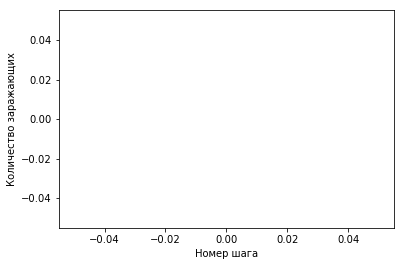

Всего заразившихся:  1  p:  0.01


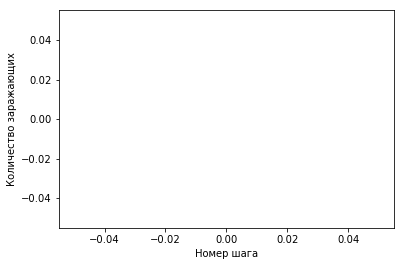

Всего заразившихся:  1  p:  0.1


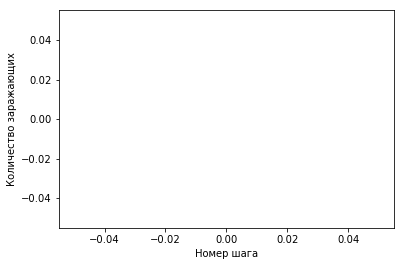

Всего заразившихся:  1  p:  0.3


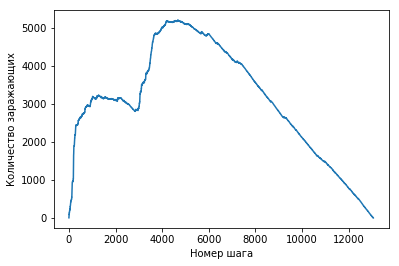

Всего заразившихся:  13061  p:  0.7


In [14]:
#Начинаем с вершины co случайной вершины

for p in p_range:
    start = [random.choice(list(G.nodes()))]
    simple_spread(G, start, p, True)


0.01


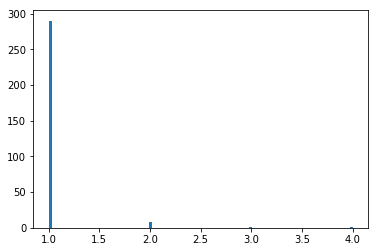

                0
count  300.000000
mean     1.043333
std      0.261438
min      1.000000
25%      1.000000
50%      1.000000
75%      1.000000
max      4.000000
0.1


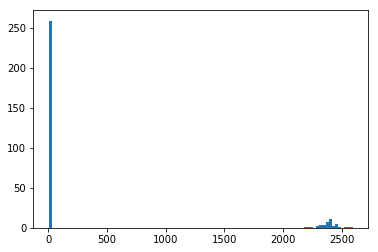

                 0
count   300.000000
mean    327.590000
std     821.716168
min       1.000000
25%       1.000000
50%       1.000000
75%       2.000000
max    2596.000000
0.3


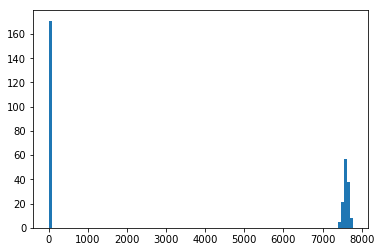

                 0
count   300.000000
mean   3266.073333
std    3765.450083
min       1.000000
25%       1.000000
50%       2.000000
75%    7589.000000
max    7774.000000
0.7


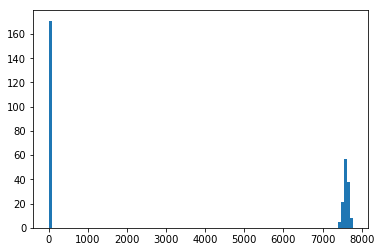

                  0
count    300.000000
mean   10710.160000
std     5139.006842
min        1.000000
25%    13092.250000
50%    13159.000000
75%    13198.000000
max    13305.000000
Wall time: 9min 25s


In [15]:
%%time
###2
#начинаем со случайной вершины в насемплированных

res01 = []
res1 = []
res3 = []
res7 = []

for i in tqdm_notebook(range(N)):
    GSampled = nx.read_edgelist("sample-graph\graph-" + str(i), 'rb')
    res01.append(simple_spread(GSampled, [random.choice(list(GSampled.nodes()))], 0.01, False)[0])
    res1.append(simple_spread(GSampled, [random.choice(list(GSampled.nodes()))], 0.1, False)[0])
    res3.append(simple_spread(GSampled, [random.choice(list(GSampled.nodes()))], 0.3, False)[0])
    res7.append(simple_spread(GSampled, [random.choice(list(GSampled.nodes()))], 0.7, False)[0])

print(0.01)    
plt.hist(res01, bins=100)
plt.show()
print(pd.DataFrame(res01).describe())

print(0.1)
plt.hist(res1, bins=100)
plt.show()
print(pd.DataFrame(res1).describe())


print(0.3)
plt.hist(res3, bins=100)
plt.show()
print(pd.DataFrame(res3).describe())

print(0.7)
plt.hist(res3, bins=100)
plt.show()
print(pd.DataFrame(res7).describe())



0.01



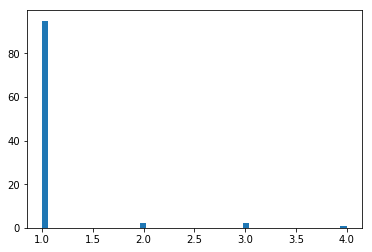

                0
count  100.000000
mean     1.090000
std      0.428646
min      1.000000
25%      1.000000
50%      1.000000
75%      1.000000
max      4.000000
0.1



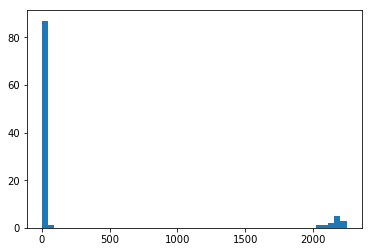

                 0
count   100.000000
mean    262.600000
std     709.482355
min       1.000000
25%       1.000000
50%       1.000000
75%       2.000000
max    2248.000000
0.3



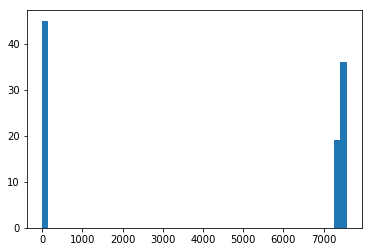

                 0
count   100.000000
mean   4090.060000
std    3717.082159
min       1.000000
25%       1.000000
50%    7320.000000
75%    7446.000000
max    7567.000000
0.7



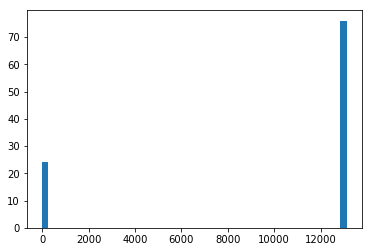

                  0
count    100.000000
mean    9897.930000
std     5589.593358
min        1.000000
25%    12919.000000
50%    13004.500000
75%    13040.500000
max    13116.000000
Wall time: 29.6 s


In [16]:
%%time
###2
#начинаем со случайной вершины в исходном
for p in p_range:
    print(p)
    res = []
    for i in tqdm_notebook(range(100)):
        res.append(simple_spread(G,[random.choice(list(G.nodes()))], p, False)[0])        
    plt.hist(res, bins=50)
    plt.show()
    print(pd.DataFrame(res).describe())

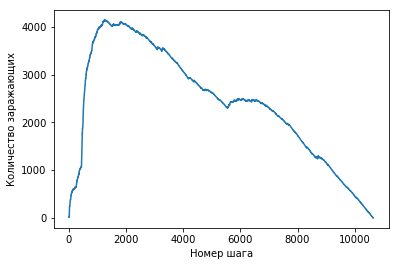

Всего заразившихся:  10652  p:  0.5



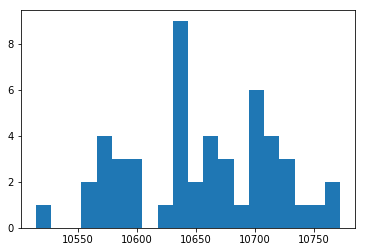

                  0
count     50.000000
mean   10654.220000
std       60.331158
min    10514.000000
25%    10605.250000
50%    10654.500000
75%    10705.000000
max    10772.000000
Wall time: 23.8 s


In [17]:
%%time
###3
#Начинаем с 5*3 случайных вершин из топ-комьюнити

partition = community.best_partition(G)
groups = dict()
for n, v in partition.items():

    if v in groups.keys():
        groups[v].add(n)
    else:
        groups[v] = set([n])
group_size = [(idx, len(groups[idx])) for idx in groups]
group_size.sort(key=lambda s: -s[1])



sample = []
for i in range(5):
    idx = group_size[i][0]
    sample.extend(random.sample(groups[idx], 3))
    
simple_spread(G, sample , 0.5, True)

res = []
for _ in tqdm_notebook(range(50)):
    sample = []    
    for i in range(5):
        idx = group_size[i][0]
        sample.extend(random.sample(groups[idx], 3))
    res.append(simple_spread(G, sample, 0.5, False)[0])
    
plt.hist(res, bins=20)
plt.show()
print(pd.DataFrame(res).describe())

In [18]:
#4

In [19]:
data = pd.read_csv('Downloads\pcbi.1001109.s001.csv', delimiter = ';', header=None)
data[0] = data[0].apply(lambda s: 'f'+str(s))
data[1] = data[1].apply(lambda s: 'm'+str(s))

In [20]:


GW = nx.Graph()
for _, f, m, t, _,_, _,_ in data.itertuples():
    GW.add_edge(f, m, weight=t)
sorted_edges = sorted(GW.edges(data=True), key=lambda e: e[2]['weight'])

In [21]:
def time_spread(sorted_edges, start,p=1, show=False):
    infected = set()
    infected.update(start)
    number_infected_day = Counter()
    for a, b, t in sorted_edges:
        if (a in infected and b not in infected) or (b in infected and a not in infected):
            prob = np.random.random()
            if prob < p:
                infected.add(a)
                infected.add(b)
                number_infected_day[t['weight']] += 1
                
            
        
    if show:       
        by_day = sorted([[key, number_infected_day[key]] for key in number_infected_day], key = lambda s: s[1])
        total = by_day[:1]
        for key, num in by_day[1:]:
            total.append([key, num + total[-1][1]])
        plt.plot(list(range(len(total))), [num for _, num in total])  
        plt.xlabel('День')
        plt.ylabel('Количество зараженных')

        plt.show()
        print("Всего заразившихся: ", len(infected), " p: ", p)            
    else:
        return len(infected)

    

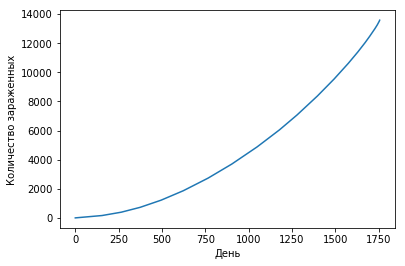

Всего заразившихся:  13575  p:  1


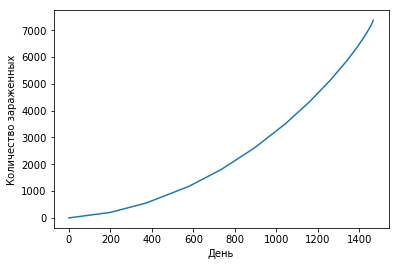

Всего заразившихся:  7371  p:  0.5


In [22]:
#графики для исходного графа
time_spread(sorted_edges, ['f0'],p=1, show=True)
time_spread(sorted_edges, ['f0'],p=0.5, show=True)

In [23]:
#функция, возвращающая граф с перемешанными временами
def time_mixed(data):
    data_copy = data.copy()
    times = data[2].tolist()
    np.random.shuffle(times)
    data_copy[2] = times
    GWSampled = nx.Graph()
    for _, f, m, t, _,_, _,_ in data_copy.itertuples():
        GWSampled.add_edge(f, m, weight=t)
    return sorted(GWSampled.edges(data=True), key=lambda e: e[2]['weight'])

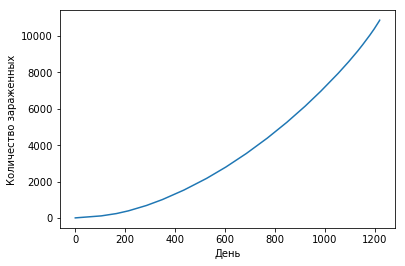

Всего заразившихся:  10873  p:  1


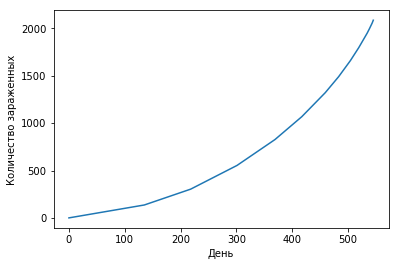

Всего заразившихся:  2086  p:  0.5


In [24]:
#график для случайного графа
time_spread(time_mixed(data), ['f0'],p=1, show=True)
time_spread(time_mixed(data), ['f0'],p=0.5, show=True)

In [31]:
partition = community.best_partition(G)
groups = dict()
for n, v in partition.items():

    if v in groups.keys():
        groups[v].add(n)
    else:
        groups[v] = set([n])
group_size = [(idx, len(groups[idx])) for idx in groups]
group_size.sort(key=lambda s: -s[1])



sample = []
for i in range(5):
    idx = group_size[i][0]
    sample.extend(random.sample(groups[idx], 3))

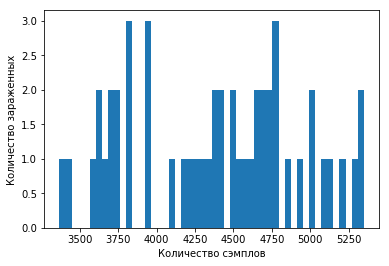

                 0
count    50.000000
mean   4380.160000
std     543.096164
min    3369.000000
25%    3862.500000
50%    4423.000000
75%    4755.250000
max    5347.000000


In [38]:
#подсчет статистик для исходного графов
res = []
for _ in tqdm_notebook(range(50)):
    res.append(time_spread(sorted_edges, sample,p=0.5, show=False))

plt.hist(res, bins=50)
plt.xlabel('Количество сэмплов')
plt.ylabel('Количество зараженных')
plt.show()
print(pd.DataFrame(res).describe())
    

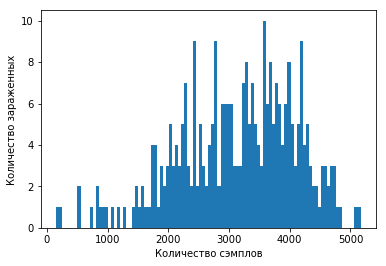

                 0
count   300.000000
mean   3127.096667
std     971.068239
min     154.000000
25%    2447.750000
50%    3253.500000
75%    3861.500000
max    5166.000000


In [39]:
#подсчет статистик для сэмплированных графов
res = []
for _ in tqdm_notebook(range(300)):
    res.append(time_spread(time_mixed(data), sample,p=0.5, show=False))

plt.hist(res, bins=100)
plt.xlabel('Количество сэмплов')
plt.ylabel('Количество зараженных')
plt.show()
print(pd.DataFrame(res).describe())